In [ ]:
!pip install joblib

In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
from sklearn.preprocessing import LabelEncoder

##Modelo de regresión logistica

In [ ]:
df = pd.read_csv("dataset.csv")

In [ ]:
X = df["text"]
y = df["label"]

In [ ]:
X

,text
0,GOBERNACION DE Boyaca Oficina Asesora Para la ...
1,Gobernación de Cundinamarca LA SECRETARIA GENE...
2,0007 FONDO DE DESARROLLO LOCAL DE BOSA BOGOTA ...
3,Instituto Colombiano de Bienestar Familiar Cec...
4,SECRETARIA DE PLANEACIÓN Sincelejo Unidos tran...
...,...
180,PRESIDENCIA DE LA REPUBLICA RESOLUCION NÚMERO ...
181,REPUBLICA DE COLOMBIA PRESIDENCIA DE LA REPUBL...
182,PROCURADURIA NACION RESOLUCIÓN NO. 138 DEL 19 ...
183,25 REPUBLICA DE COLOMBIA DEPARTAMENTO ADMINIST...


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=5000)),
    ("clf", LogisticRegression(max_iter=1000))
])

In [ ]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=5000)),
                ('clf', LogisticRegression(max_iter=1000))])

In [ ]:
y_pred = pipeline.predict(X_test)

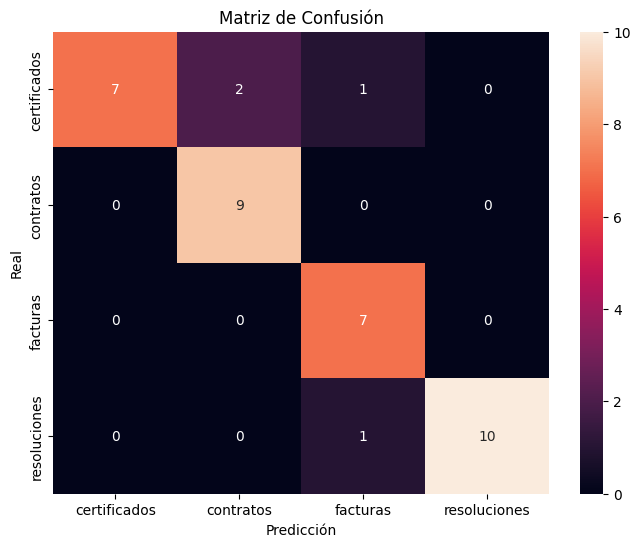

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", xticklabels=pipeline.classes_, yticklabels=pipeline.classes_)
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print("=== Métricas globales ===")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

print("\n=== Reporte de clasificación por clase ===")
print(classification_report(y_test, y_pred))

=== Métricas globales ===
Accuracy:  0.8919
Precision: 0.9137
Recall:    0.8919
F1 Score:  0.8902

=== Reporte de clasificación por clase ===
              precision    recall  f1-score   support

certificados       1.00      0.70      0.82        10
   contratos       0.82      1.00      0.90         9
    facturas       0.78      1.00      0.88         7
resoluciones       1.00      0.91      0.95        11

    accuracy                           0.89        37
   macro avg       0.90      0.90      0.89        37
weighted avg       0.91      0.89      0.89        37



In [ ]:
joblib.dump(pipeline, "modelo1_documentos.pkl")

['modelo1_documentos.pkl']

##Entrenamiento con limpieza de datos y regresión logistica

In [ ]:
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
stop_words = set(stopwords.words("spanish"))
stemmer = SnowballStemmer("spanish")
tokenizer = RegexpTokenizer(r'\b\w+\b')

In [ ]:
def limpiar_texto(texto):
    texto = texto.lower()
    texto = re.sub(r"\s+", " ", texto).strip()
    tokens = tokenizer.tokenize(texto)
    tokens = [stemmer.stem(palabra) for palabra in tokens if palabra not in stop_words]
    return " ".join(tokens)

In [ ]:
X = df["text"].apply(limpiar_texto)
y = df["label"]

In [ ]:
X

,text
0,gobern boyac oficin asesor gestion estrateg se...
1,gobern cundinamarc secretari general cercani c...
2,0007 fond desarroll local bos bogot unid ejecu...
3,institut colombian bienest famili cecili fuent...
4,secretari planeacion sincelej unid transform c...
...,...
180,president republ resolucion numer 0111 2016 19...
181,republ colombi president republ resolu numer 0...
182,procuraduri nacion resolu 138 19 diciembr 2022...
183,25 republ colombi departament administr presid...


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
modelos = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "Linear SVM": LinearSVC(class_weight="balanced", max_iter=10000),
    "Random Forest": RandomForestClassifier(class_weight="balanced", n_estimators=100),
    "Multinomial NB": MultinomialNB()
}

In [ ]:
def evaluar_modelo(nombre, modelo, X_train, X_test, y_train, y_test):
    print(f"\n=== Modelo: {nombre} ===")
    pipeline = Pipeline([
        ("tfidf", TfidfVectorizer(max_features=5000)),
        ("clf", modelo)
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Matriz de confusión
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d",
                xticklabels=pipeline.classes_, yticklabels=pipeline.classes_)
    plt.title(f"Matriz de Confusión - {nombre}")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()

    # Métricas
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print("\nReporte de clasificación:\n")
    print(classification_report(y_test, y_pred))
    encoder = LabelEncoder()
    y_encoded = encoder.fit_transform(y_train)
    joblib.dump(pipeline, f"modelo_{nombre.lower()}_documentos.pkl")



=== Modelo: Logistic Regression ===


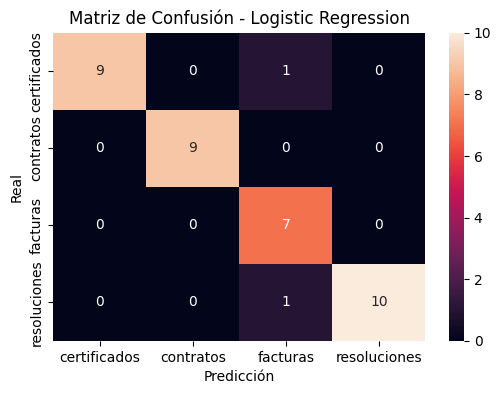

Accuracy:  0.9459
Precision: 0.9580
Recall:    0.9459
F1 Score:  0.9480

Reporte de clasificación:

              precision    recall  f1-score   support

certificados       1.00      0.90      0.95        10
   contratos       1.00      1.00      1.00         9
    facturas       0.78      1.00      0.88         7
resoluciones       1.00      0.91      0.95        11

    accuracy                           0.95        37
   macro avg       0.94      0.95      0.94        37
weighted avg       0.96      0.95      0.95        37


=== Modelo: Linear SVM ===


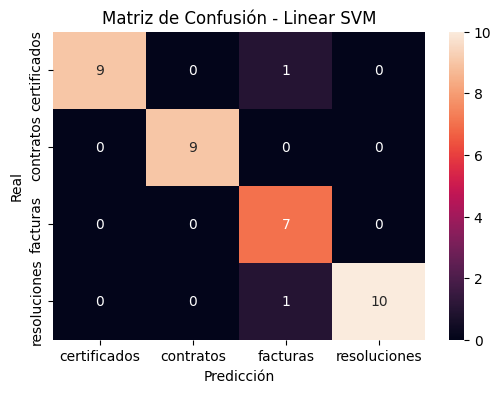

Accuracy:  0.9459
Precision: 0.9580
Recall:    0.9459
F1 Score:  0.9480

Reporte de clasificación:

              precision    recall  f1-score   support

certificados       1.00      0.90      0.95        10
   contratos       1.00      1.00      1.00         9
    facturas       0.78      1.00      0.88         7
resoluciones       1.00      0.91      0.95        11

    accuracy                           0.95        37
   macro avg       0.94      0.95      0.94        37
weighted avg       0.96      0.95      0.95        37


=== Modelo: Random Forest ===


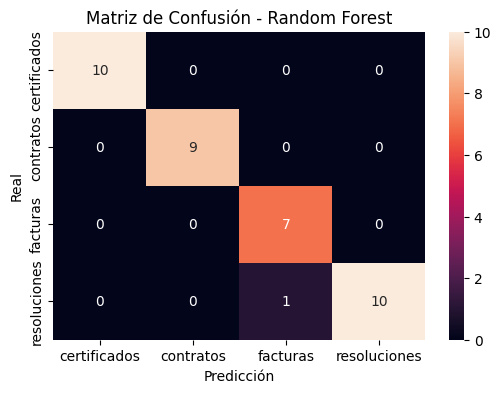

Accuracy:  0.9730
Precision: 0.9764
Recall:    0.9730
F1 Score:  0.9732

Reporte de clasificación:

              precision    recall  f1-score   support

certificados       1.00      1.00      1.00        10
   contratos       1.00      1.00      1.00         9
    facturas       0.88      1.00      0.93         7
resoluciones       1.00      0.91      0.95        11

    accuracy                           0.97        37
   macro avg       0.97      0.98      0.97        37
weighted avg       0.98      0.97      0.97        37


=== Modelo: Multinomial NB ===


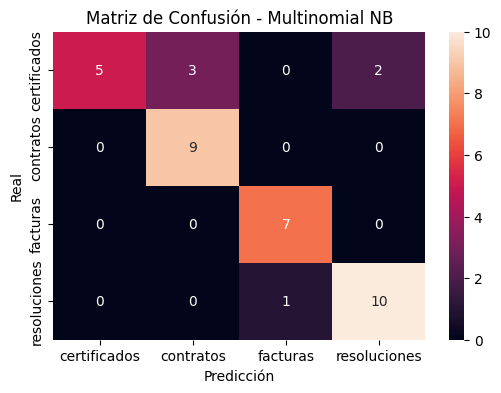

Accuracy:  0.8378
Precision: 0.8660
Recall:    0.8378
F1 Score:  0.8238

Reporte de clasificación:

              precision    recall  f1-score   support

certificados       1.00      0.50      0.67        10
   contratos       0.75      1.00      0.86         9
    facturas       0.88      1.00      0.93         7
resoluciones       0.83      0.91      0.87        11

    accuracy                           0.84        37
   macro avg       0.86      0.85      0.83        37
weighted avg       0.87      0.84      0.82        37



In [ ]:
for nombre, modelo in modelos.items():
    evaluar_modelo(nombre, modelo, X_train, X_test, y_train, y_test)